### Split the downsampled dataset

In [1]:
# import libraries:

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler
import keras
import time 
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Reshape, Dropout, Flatten
from keras.layers import MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# define directories:

packet_dataset = '/home/mcamelo/traf-reg/ns-3.29/output_data/paola_1T/out_dir/down/app/dataset.csv'
label_dataset = '/home/mcamelo/traf-reg/ns-3.29/output_data/paola_1T/out_dir/down/app/labels.csv'
out_dir = '/home/mcamelo/traf-reg/ns-3.29/output_data/paola_1T/out_dir/model'
os.makedirs(out_dir, exist_ok=True)
seed = 42 # to reproduce results

In [3]:
# define auxiliar functions:

def create_mapping(df):
    labels = df['aim'].unique()
    mapping = dict(zip(labels, range(len(labels))))
    return mapping

def create_model(in_dim, dr, num_classes):
    # start with a simple model
    model = Sequential()

    # input layer
    model.add(Reshape(in_dim, input_shape=in_dim))

    # 1st Convolutional layer, according to the parameters specified in Table 2.
    model.add(Conv1D(filters=200, kernel_size=4, strides=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))

    # 2nd Convolutional layer
    model.add(Conv1D(filters=200, kernel_size=5, strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))

    # 3. Maxpooling
    model.add(MaxPooling1D(pool_size=2, padding='same'))

    # 4. Flatten
    model.add(Flatten())

    # Fully connected network
    # 1st layer
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))

    # 2nd layer
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))

    # 3rd layer
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))


    # Classification layer
    model.add(Dense(num_classes, activation='softmax'))

    #optimizer
    adam = Adam()
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

    return model

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    h = 768
    w = 1024
    my_dpi = 96
    
    fig, ax = plt.subplots(figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

In [10]:
# load down sampled dataset: 

df = pd.read_csv(packet_dataset)
X = df.values
df = pd.read_csv(label_dataset)
mapp = create_mapping(df)
df = df.replace({'aim': mapp})
Y = df.values

In [11]:
# scaler to 0-1

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)

In [12]:
# Convert labels to categorical one-hot encoding

num_classes = len(np.unique(Y))
print(num_classes)
Y = keras.utils.to_categorical(Y, num_classes=num_classes)
print(Y.shape)

17
(69434, 17)


In [13]:
### Reshape vectors:
[r, c] = X.shape
in_dim = [1, c]
#print(in_dim)
X = np.reshape(X, (r, in_dim[0],in_dim[1]))
print(X.shape)
Y = np.reshape(Y, (r, num_classes))
print(Y.shape)

(69434, 1, 1500)
(69434, 17)


In [14]:
print(X)

[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]


In [15]:
# make split train, validation, testing datasets: 
X_train, X_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=seed)

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(55547, 1, 1500)
(6943, 1, 1500)
(6944, 1, 1500)


In [17]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(55547, 17)
(6943, 17)
(6944, 17)


In [18]:
y_val

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
print(X_train.shape)
print(y_train.shape)

(55547, 1, 1500)
(55547, 17)


In [20]:
print(X_val.shape)
print(y_val.shape)

(6943, 1, 1500)
(6943, 17)


In [21]:
# model: 
model = create_model(in_dim, 0.05, num_classes)
model.summary()

W0703 12:31:02.987238 140072279004992 deprecation_wrapper.py:119] From /home/mcamelo/anaconda3/envs/b-budget/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 12:31:03.012061 140072279004992 deprecation_wrapper.py:119] From /home/mcamelo/anaconda3/envs/b-budget/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 12:31:03.026948 140072279004992 deprecation_wrapper.py:119] From /home/mcamelo/anaconda3/envs/b-budget/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 12:31:03.122355 140072279004992 deprecation_wrapper.py:119] From /home/mcamelo/anaconda3/envs/b-budget/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_w

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 1500)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 200)            1200200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 200)            800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 200)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 200)            200200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 200)            800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 200)            0         
__________

In [22]:
# configure parameters:

nb_epoch = 300
batch_size = 128
filepath = os.path.join(out_dir, 'DP_app_model.h5')
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

#### training

In [23]:
start = time.time()
history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        verbose=2,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stop, checkpoint])
end = time.time()
print('training took: {} seconds'.format(end - start))

W0703 12:31:18.147341 140072279004992 deprecation.py:323] From /home/mcamelo/anaconda3/envs/b-budget/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55547 samples, validate on 6943 samples
Epoch 1/300
 - 99s - loss: 1.1656 - acc: 0.6109 - val_loss: 0.7956 - val_acc: 0.7402
Epoch 2/300
 - 92s - loss: 0.5801 - acc: 0.8000 - val_loss: 0.7408 - val_acc: 0.7635
Epoch 3/300
 - 93s - loss: 0.4016 - acc: 0.8634 - val_loss: 0.4727 - val_acc: 0.8308
Epoch 4/300
 - 92s - loss: 0.3367 - acc: 0.8827 - val_loss: 0.9042 - val_acc: 0.7598
Epoch 5/300
 - 89s - loss: 0.2989 - acc: 0.8936 - val_loss: 0.4210 - val_acc: 0.8537
Epoch 6/300
 - 90s - loss: 0.2731 - acc: 0.9005 - val_loss: 0.2550 - val_acc: 0.9071
Epoch 7/300
 - 92s - loss: 0.2521 - acc: 0.9080 - val_loss: 0.3064 - val_acc: 0.8898
Epoch 8/300
 - 92s - loss: 0.2425 - acc: 0.9105 - val_loss: 0.2465 - val_acc: 0.9110
Epoch 9/300
 - 92s - loss: 0.2288 - acc: 0.9137 - val_loss: 0.2579 - val_acc: 0.9093
Epoch 10/300
 - 90s - loss: 0.2202 - acc: 0.9168 - val_loss: 0.2681 - val_acc: 0.9051
Epoch 11/300
 - 90s - loss: 0.2088 - acc: 0.9201 - val_loss: 0.2227 - val_acc: 0.9139
Epoch 12/300
 

Epoch 96/300
 - 90s - loss: 0.0727 - acc: 0.9713 - val_loss: 0.2450 - val_acc: 0.9385
Epoch 97/300
 - 91s - loss: 0.0755 - acc: 0.9697 - val_loss: 0.2040 - val_acc: 0.9471
Epoch 98/300
 - 91s - loss: 0.0731 - acc: 0.9702 - val_loss: 0.2220 - val_acc: 0.9445
Epoch 99/300
 - 93s - loss: 0.0721 - acc: 0.9719 - val_loss: 0.2377 - val_acc: 0.9414
Epoch 100/300
 - 93s - loss: 0.0740 - acc: 0.9704 - val_loss: 0.2072 - val_acc: 0.9461
Epoch 101/300
 - 94s - loss: 0.0740 - acc: 0.9692 - val_loss: 0.2032 - val_acc: 0.9513
Epoch 102/300
 - 92s - loss: 0.0761 - acc: 0.9696 - val_loss: 0.2027 - val_acc: 0.9519
Epoch 103/300
 - 95s - loss: 0.0716 - acc: 0.9720 - val_loss: 0.2069 - val_acc: 0.9418
Epoch 104/300
 - 91s - loss: 0.0712 - acc: 0.9711 - val_loss: 0.2105 - val_acc: 0.9479
Epoch 105/300
 - 91s - loss: 0.0718 - acc: 0.9710 - val_loss: 0.2065 - val_acc: 0.9510
Epoch 106/300
 - 91s - loss: 0.0722 - acc: 0.9724 - val_loss: 0.2624 - val_acc: 0.9421
Epoch 107/300
 - 91s - loss: 0.0676 - acc: 0.97

In [24]:
model.load_weights(filepath)

In [25]:
results = model.evaluate(X_test, y_test, verbose=2)

In [26]:
# loss 
print(results[0])

0.1826687953826512


In [27]:
# accuracy
print(results[1])

0.9573732718894009


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


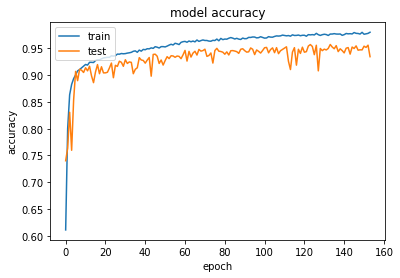

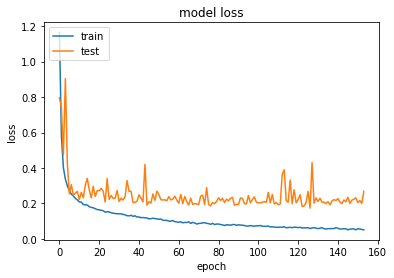

In [28]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
Y_pred = np.argmax(model.predict(X_test, verbose=2), axis=1)
y_test = np.argmax(y_test, axis=1)

In [30]:
np.set_printoptions(precision=2)
class_names = list(mapp.keys())

Confusion matrix, without normalization


(<Figure size 1024x768 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6464037710>)

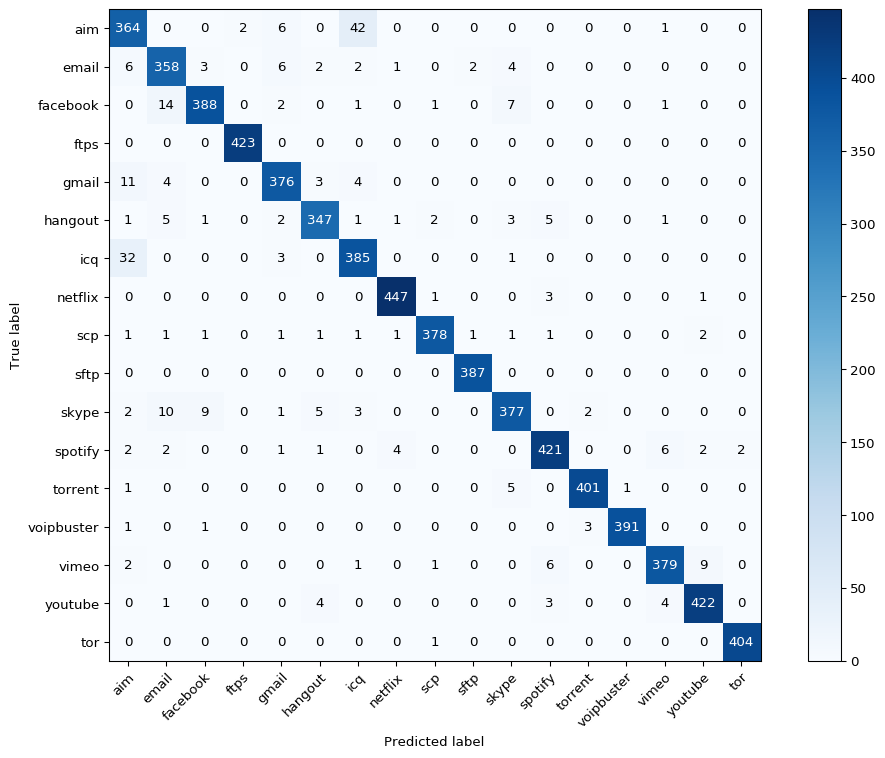

In [31]:
plot_confusion_matrix(y_test, Y_pred, classes=class_names, title='Confusion matrix app identification')

Normalized confusion matrix


(<Figure size 1024x768 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f64365d34a8>)

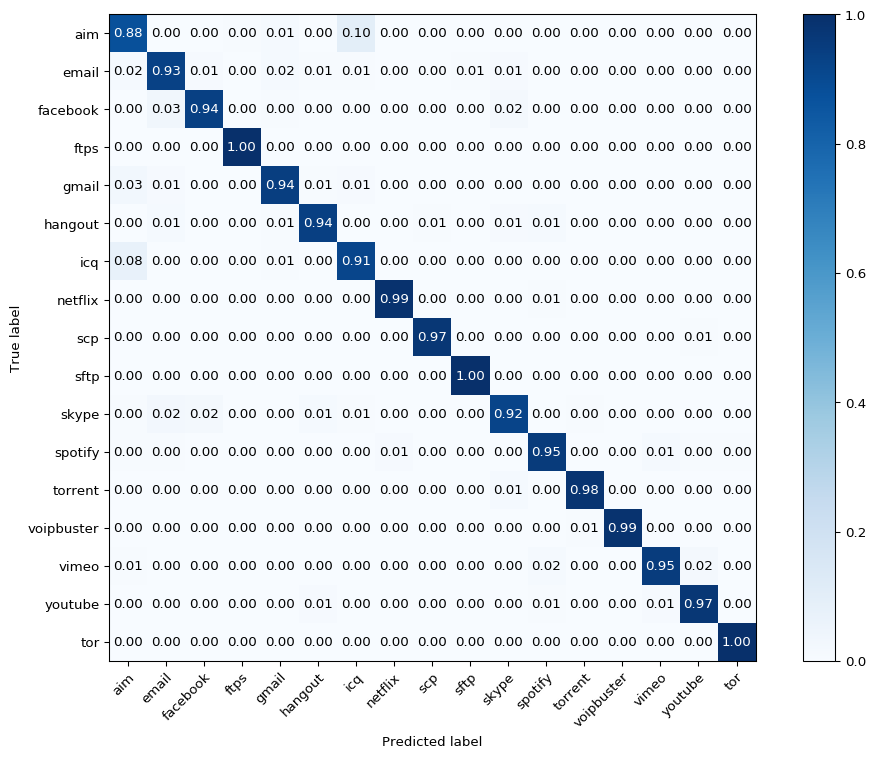

In [32]:
plot_confusion_matrix(y_test, Y_pred, classes=class_names, normalize=True, title='Confusion matrix app identification', )